In [0]:
from fastai import *
from fastai.vision import *

In [2]:
! git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 13.19 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
path = Path('/content/SegNet-Tutorial/CamVid')

In [4]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08075.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_07991.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08049.png')]

In [5]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08075.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_07991.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08049.png')]

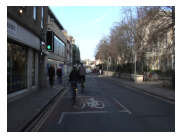

In [6]:
img = fnames[0]
img = open_image(img)
img.show(figsize=(3,3))

In [0]:
def get_y_fn(x): 
  return Path(str(x.parent)+'annot')/x.name

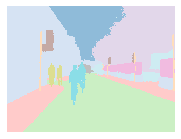

In [9]:
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(3,3))

In [10]:
mask.shape, mask.size

(torch.Size([1, 360, 480]), torch.Size([360, 480]))

In [0]:
size = mask.size
bs=8

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [0]:
codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [0]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [17]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
dest = Path("/content/gdrive/My Drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load(dest/'stage-2');

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


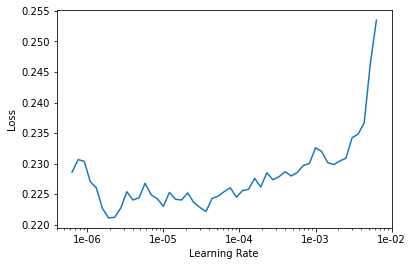

In [22]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.228450,0.251393,0.924231,01:39
1,0.228768,0.261593,0.920969,01:34
2,0.227130,0.257125,0.925209,01:34
3,0.225221,0.249514,0.924233,01:34
4,0.223336,0.250471,0.926775,01:34
5,0.220723,0.253737,0.925792,01:34
6,0.215739,0.275296,0.922702,01:35
7,0.212009,0.243711,0.929577,01:35
8,0.205083,0.239833,0.933103,01:35
9,0.195119,0.232171,0.933378,01:35


In [0]:
learn.save(dest/'stage-1-big')

In [0]:
learn.load(dest/'stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [29]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.181966,0.234529,0.932755,01:42
1,0.183968,0.233250,0.932643,01:40
2,0.181991,0.234586,0.932954,01:40
3,0.182375,0.234396,0.932006,01:40
4,0.180754,0.232810,0.933430,01:40
5,0.178368,0.231698,0.932952,01:40
6,0.176898,0.232021,0.933657,01:40
7,0.174033,0.233321,0.933573,01:40
8,0.172833,0.228512,0.934756,01:40
9,0.173069,0.228197,0.934990,01:40


In [0]:
learn.save(dest/'stage-2-big')

In [0]:
learn.load(dest/'stage-2-big');

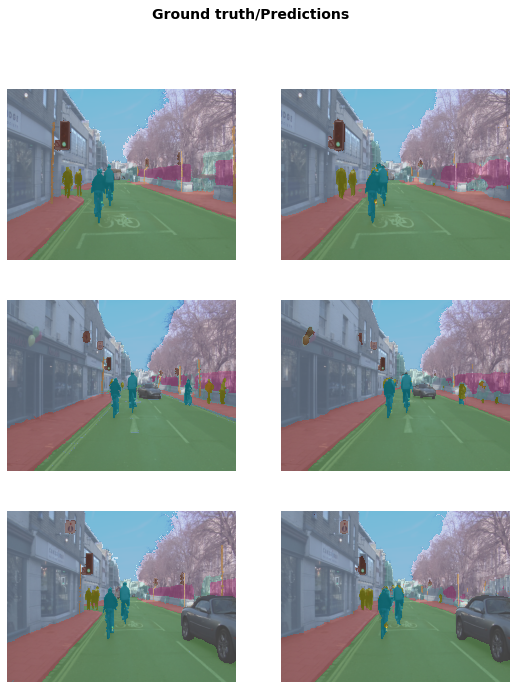

In [33]:
learn.show_results(rows=3, figsize=(9,11))